In [41]:
import os
#os.nice(10)
import glob
import mne
import csv
import matplotlib.pyplot as plt
import numpy as np
import scipy
from fooof import FOOOF, FOOOFGroup, fit_fooof_3d
from fooof.sim.gen import gen_aperiodic
import json

In [42]:
c3_chans=["C3", "FC3", "CP3", "C1"]
c4_chans=["C4", "FC4", "CP4","C2"]
c_chans=[]
c_chans.extend(c3_chans)
c_chans.extend(c4_chans)

In [43]:
def compute_psds(age):
    subjects=[os.path.split(x)[-1] for x in glob.glob('/home/common/bonaiuto/devmobeta/data/sub-*')]
    subject_age_path=os.path.join('/home/common/bonaiuto/devmobeta/derivatives/')
    subject_age= os.path.join(subject_age_path,'participants_v2.csv')

    sub_psds=[]
    freqs=None
    processed_subjects = []
            
    with open(subject_age, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            print("Processing row:", row)
            subject=row['subject_id']
            session=row['session']
            subject_age = row['age']
            system=row['eeg_system']

            if system != "BrainVision":
                print(f"Skipping subject {subject} (EEG system: {system})")
                continue 
                            
            if subject_age==age:
                print(f"Processing subject {subject} with age {subject_age}(BrainVision)")
                sub_path=os.path.join('/home/common/bonaiuto/devmobeta/derivatives/',subject)
                ses_path=os.path.join(sub_path, session)
                print(ses_path)
                
                if os.path.exists(os.path.join(ses_path,'eeg','NEARICA_NF')): 
                    print(f"Processing subject {subject} with age {subject_age} and session {session}")
                    eeg_path=os.path.join(ses_path,'eeg','NEARICA_NF')
                    fname=os.path.join(eeg_path, f'03_ica_data/{subject}_task-devmobeta_grasp_eeg_ica_art_rej_interp_reref.set')
                    if os.path.exists(fname):
                        raw_data=mne.io.read_raw_eeglab(fname, preload=True)
                        srate=raw_data.info['sfreq']

                        c_chan_idx=[]
                        for chan in c_chans:
                            if chan in raw_data.info['ch_names']:
                                c_chan_idx.append(raw_data.info['ch_names'].index(chan))
                        c_chan_idx=np.array(c_chan_idx)
                        
                        if len(c_chan_idx)==len(c_chans):
            
                            data=raw_data.get_data()
                            n_chans=data.shape[0]
                            n_samps=data.shape[1]

                            # Use a window size of 1s with a 50% overlap
                            winsize=srate
                            overlap=int(winsize/2)    

                            chan_data=data[c_chan_idx,:]
                            freqs, chan_psd=scipy.signal.welch(
                                chan_data, 
                                fs=srate, 
                                window='hann', 
                                nperseg=winsize, 
                                noverlap=overlap, 
                                nfft=int(winsize*20),
                                detrend='constant',
                                return_onesided=True, 
                                scaling='density', 
                                axis=- 1, 
                                average='mean'
                            )
                            f_idx=(freqs<=40)
                            freqs=freqs[f_idx]
                            chan_psd=chan_psd[:,f_idx]
                            sub_psds.append(chan_psd)
                            processed_subjects.append(subject)
                else: 
                    print (f"Processing subject {subject} with age {subject_age} and {session} doesn't exist")
    print(f"\n=== Summary ===")
    print(f"Subjects processed for age {age}: {processed_subjects}")
    print(f"Total: {len(processed_subjects)} subjects\n")
    sub_psds=np.array(sub_psds)
    return freqs, sub_psds

In [44]:
freqs, sub_three_psds=compute_psds('three')
freqs, sub_six_psds=compute_psds('six')
freqs, sub_twelve_psds=compute_psds('twelve')

Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Skipping subject sub-201 (EEG system: EGI)
Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-201 (EEG system: )
Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-201 (EEG system: )
Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Skipping subject sub-201 (EEG system: EGI)
Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-201 (EEG system: )
Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-06', 'age': 't

/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-250', 'orig_participant_id': 'PZ', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-250', 'orig_participant_id': 'PZ', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-250 (EEG system: )
Processing row: {'subject_id': 'sub-251', 'orig_participant_id': 'AP', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-251 (EEG system: )
Processing row: {'subject_id': 'sub-251', 'orig_participant_id': 'AP', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-251 (EEG system: )
Processing row: {'subject_id': 'sub-251', 'orig_participant_id': 'AP', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-251 (EEG system: )
Processing row: {'subject_id': 'sub-252', 'orig_participant_id': 'TE', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainV

/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-252', 'orig_participant_id': 'TE', 'session': 'ses-02', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-253', 'orig_participant_id': 'RS', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing subject sub-253 with age three(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-253/ses-01
Processing subject sub-253 with age three and session ses-01


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-253', 'orig_participant_id': 'RS', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-253', 'orig_participant_id': 'RS', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-254', 'orig_participant_id': 'SF', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing subject sub-254 with age three(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-254/ses-01
Processing subject sub-254 with age three and session ses-01


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-254', 'orig_participant_id': 'SF', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-254', 'orig_participant_id': 'SF', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-255', 'orig_participant_id': 'LH', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing subject sub-255 with age three(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-255/ses-01
Processing subject sub-255 with age three and session ses-01


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-255', 'orig_participant_id': 'LH', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-255', 'orig_participant_id': 'LH', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-255 (EEG system: )
Processing row: {'subject_id': 'sub-256', 'orig_participant_id': 'AS', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing subject sub-256 with age three(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-256/ses-01
Processing subject sub-256 with age three and session ses-01


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-257', 'orig_participant_id': 'CGM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing subject sub-257 with age three(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-257/ses-01
Processing subject sub-257 with age three and session ses-01


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-258', 'orig_participant_id': 'AG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing subject sub-258 with age three(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-258/ses-01
Processing subject sub-258 with age three and session ses-01


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-258', 'orig_participant_id': 'AG', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-258', 'orig_participant_id': 'AG', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-258 (EEG system: )
Processing row: {'subject_id': 'sub-259', 'orig_participant_id': 'MR', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-259', 'orig_participant_id': 'MR', 'session': 'ses-02', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-259 (EEG system: )
Processing row: {'subject_id': 'sub-260', 'orig_participant_id': 'OD', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing subject sub-260 with age three(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-260/ses-01
Processing subject sub-260 with age three and session ses-01
Processing row: {'subjec

/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-261', 'orig_participant_id': 'ML', 'session': 'ses-02', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-262', 'orig_participant_id': 'AK', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing subject sub-262 with age three(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-262/ses-01
Processing subject sub-262 with age three and session ses-01


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-262', 'orig_participant_id': 'AK', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-262', 'orig_participant_id': 'AK', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-262 (EEG system: )
Processing row: {'subject_id': 'sub-263', 'orig_participant_id': 'EOG', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-263 (EEG system: )
Processing row: {'subject_id': 'sub-264', 'orig_participant_id': 'AH', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing subject sub-264 with age three(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-264/ses-01
Processing subject sub-264 with age three and session ses-01
Processing row: {'subject_id': 'sub-264', 'orig_participant_id': 'AH', 'session': 'ses-02', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'sub

/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-265', 'orig_participant_id': 'EB ', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-265', 'orig_participant_id': 'EB ', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-266', 'orig_participant_id': 'LC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing subject sub-266 with age three(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-266/ses-01
Processing subject sub-266 with age three and session ses-01


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-266', 'orig_participant_id': 'LC', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-266', 'orig_participant_id': 'LC', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-267', 'orig_participant_id': 'FC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing subject sub-267 with age three(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-267/ses-01
Processing subject sub-267 with age three and session ses-01


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-267', 'orig_participant_id': 'FC', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-268', 'orig_participant_id': 'LA', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-268 (EEG system: )
Processing row: {'subject_id': 'sub-268', 'orig_participant_id': 'LA', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-269', 'orig_participant_id': 'OHM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing subject sub-269 with age three(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-269/ses-01
Processing subject sub-269 with age three and session ses-01


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-269', 'orig_participant_id': 'OHM', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-270', 'orig_participant_id': 'LP', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-270 (EEG system: )
Processing row: {'subject_id': 'sub-270', 'orig_participant_id': 'LP', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-270', 'orig_participant_id': 'LP', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-271', 'orig_participant_id': 'SPP', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-272', 'orig_participant_id': 'SB', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-272', 'orig_participant_id': 'SB', 'session': 

/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-274', 'orig_participant_id': 'VT', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-275', 'orig_participant_id': 'LJCT', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-275', 'orig_participant_id': 'LJCT', 'session': 'ses-02', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-276', 'orig_participant_id': 'EG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing subject sub-276 with age three(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-276/ses-01
Processing subject sub-276 with age three and session ses-01


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-276', 'orig_participant_id': 'EG', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-276', 'orig_participant_id': 'EG', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-277', 'orig_participant_id': 'JA', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing subject sub-277 with age three(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-277/ses-01
Processing subject sub-277 with age three and session ses-01


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-278', 'orig_participant_id': 'EC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing subject sub-278 with age three(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-278/ses-01
Processing subject sub-278 with age three and session ses-01


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-278', 'orig_participant_id': 'EC', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-278', 'orig_participant_id': 'EC', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-279', 'orig_participant_id': 'LS', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-279 (EEG system: )
Processing row: {'subject_id': 'sub-279', 'orig_participant_id': 'LS', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-280', 'orig_participant_id': 'ADR', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-280 (EEG system: )
Processing row: {'subject_id': 'sub-280', 'orig_participant_id': 'ADR', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}

=== Summary ===
Subjects processed for age three: 

/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-250', 'orig_participant_id': 'PZ', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-250 (EEG system: )
Processing row: {'subject_id': 'sub-251', 'orig_participant_id': 'AP', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-251 (EEG system: )
Processing row: {'subject_id': 'sub-251', 'orig_participant_id': 'AP', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-251 (EEG system: )
Processing row: {'subject_id': 'sub-251', 'orig_participant_id': 'AP', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-251 (EEG system: )
Processing row: {'subject_id': 'sub-252', 'orig_participant_id': 'TE', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-252', 'orig_participant_id': 'TE', 'session': 'ses-02', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'Bra

/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-253', 'orig_participant_id': 'RS', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-254', 'orig_participant_id': 'SF', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-254', 'orig_participant_id': 'SF', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing subject sub-254 with age six(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-254/ses-02
Processing subject sub-254 with age six and session ses-02


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-254', 'orig_participant_id': 'SF', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-255', 'orig_participant_id': 'LH', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-255', 'orig_participant_id': 'LH', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing subject sub-255 with age six(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-255/ses-02
Processing subject sub-255 with age six and session ses-02


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-255', 'orig_participant_id': 'LH', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-255 (EEG system: )
Processing row: {'subject_id': 'sub-256', 'orig_participant_id': 'AS', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-257', 'orig_participant_id': 'CGM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-258', 'orig_participant_id': 'AG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-258', 'orig_participant_id': 'AG', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing subject sub-258 with age six(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-258/ses-02
Processing subject sub-258 with age six and session ses-02


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-258', 'orig_participant_id': 'AG', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-258 (EEG system: )
Processing row: {'subject_id': 'sub-259', 'orig_participant_id': 'MR', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing subject sub-259 with age six(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-259/ses-01
Processing subject sub-259 with age six and session ses-01
Processing row: {'subject_id': 'sub-259', 'orig_participant_id': 'MR', 'session': 'ses-02', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-259 (EEG system: )
Processing row: {'subject_id': 'sub-260', 'orig_participant_id': 'OD', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-260', 'orig_participant_id': 'OD', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing subject sub-260 w

/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing subject sub-260 with age six and session ses-02
Processing row: {'subject_id': 'sub-261', 'orig_participant_id': 'ML', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-261', 'orig_participant_id': 'ML', 'session': 'ses-02', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-262', 'orig_participant_id': 'AK', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-262', 'orig_participant_id': 'AK', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing subject sub-262 with age six(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-262/ses-02
Processing subject sub-262 with age six and session ses-02


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-262', 'orig_participant_id': 'AK', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-262 (EEG system: )
Processing row: {'subject_id': 'sub-263', 'orig_participant_id': 'EOG', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-263 (EEG system: )
Processing row: {'subject_id': 'sub-264', 'orig_participant_id': 'AH', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-264', 'orig_participant_id': 'AH', 'session': 'ses-02', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-265', 'orig_participant_id': 'EB ', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-265', 'orig_participant_id': 'EB ', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing subject sub-265 with age six(Brain

/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-265', 'orig_participant_id': 'EB ', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-266', 'orig_participant_id': 'LC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-266', 'orig_participant_id': 'LC', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing subject sub-266 with age six(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-266/ses-02
Processing subject sub-266 with age six and session ses-02


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-266', 'orig_participant_id': 'LC', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-267', 'orig_participant_id': 'FC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-267', 'orig_participant_id': 'FC', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing subject sub-267 with age six(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-267/ses-02
Processing subject sub-267 with age six and session ses-02


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-268', 'orig_participant_id': 'LA', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-268 (EEG system: )
Processing row: {'subject_id': 'sub-268', 'orig_participant_id': 'LA', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing subject sub-268 with age six(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-268/ses-02
Processing subject sub-268 with age six and session ses-02


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-269', 'orig_participant_id': 'OHM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-269', 'orig_participant_id': 'OHM', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing subject sub-269 with age six(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-269/ses-02
Processing subject sub-269 with age six and session ses-02


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-270', 'orig_participant_id': 'LP', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-270 (EEG system: )
Processing row: {'subject_id': 'sub-270', 'orig_participant_id': 'LP', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing subject sub-270 with age six(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-270/ses-02
Processing subject sub-270 with age six and session ses-02


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-270', 'orig_participant_id': 'LP', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-271', 'orig_participant_id': 'SPP', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing subject sub-271 with age six(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-271/ses-01
Processing subject sub-271 with age six and session ses-01


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-272', 'orig_participant_id': 'SB', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing subject sub-272 with age six(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-272/ses-01
Processing subject sub-272 with age six and session ses-01
Processing row: {'subject_id': 'sub-272', 'orig_participant_id': 'SB', 'session': 'ses-02', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-272 (EEG system: )
Processing row: {'subject_id': 'sub-273', 'orig_participant_id': 'NL', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing subject sub-273 with age six(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-273/ses-01
Processing subject sub-273 with age six and session ses-01


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-273', 'orig_participant_id': 'NL', 'session': 'ses-02', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-274', 'orig_participant_id': 'VT', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-274', 'orig_participant_id': 'VT', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing subject sub-274 with age six(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-274/ses-02
Processing subject sub-274 with age six and session ses-02


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-275', 'orig_participant_id': 'LJCT', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing subject sub-275 with age six(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-275/ses-01
Processing subject sub-275 with age six and session ses-01
Processing row: {'subject_id': 'sub-275', 'orig_participant_id': 'LJCT', 'session': 'ses-02', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-276', 'orig_participant_id': 'EG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-276', 'orig_participant_id': 'EG', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing subject sub-276 with age six(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-276/ses-02
Processing subject sub-276 with age six and session ses-02


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-276', 'orig_participant_id': 'EG', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-277', 'orig_participant_id': 'JA', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-278', 'orig_participant_id': 'EC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-278', 'orig_participant_id': 'EC', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing subject sub-278 with age six(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-278/ses-02
Processing subject sub-278 with age six and session ses-02


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-278', 'orig_participant_id': 'EC', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-279', 'orig_participant_id': 'LS', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-279 (EEG system: )
Processing row: {'subject_id': 'sub-279', 'orig_participant_id': 'LS', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing subject sub-279 with age six(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-279/ses-02
Processing subject sub-279 with age six and session ses-02


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-280', 'orig_participant_id': 'ADR', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-280 (EEG system: )
Processing row: {'subject_id': 'sub-280', 'orig_participant_id': 'ADR', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing subject sub-280 with age six(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-280/ses-02
Processing subject sub-280 with age six and session ses-02


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)



=== Summary ===
Subjects processed for age six: ['sub-250', 'sub-253', 'sub-254', 'sub-255', 'sub-258', 'sub-259', 'sub-260', 'sub-262', 'sub-265', 'sub-266', 'sub-267', 'sub-268', 'sub-269', 'sub-270', 'sub-271', 'sub-273', 'sub-274', 'sub-276', 'sub-278', 'sub-279', 'sub-280']
Total: 21 subjects

Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Skipping subject sub-201 (EEG system: EGI)
Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-201 (EEG system: )
Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-201 (EEG system: )
Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Skipping subject sub-2

/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-239', 'orig_participant_id': 'ABV', 'session': 'ses-01', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-239 (EEG system: )
Processing row: {'subject_id': 'sub-239', 'orig_participant_id': 'ABV', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Skipping subject sub-239 (EEG system: EGI)
Processing row: {'subject_id': 'sub-239', 'orig_participant_id': 'ABV', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-239 (EEG system: )
Processing row: {'subject_id': 'sub-240', 'orig_participant_id': 'ABV', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-240 (EEG system: )
Processing row: {'subject_id': 'sub-240', 'orig_participant_id': 'ABV', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Skipping subject sub-240 (EEG system: EGI)
Processing row: {'subject_id': 'sub-240', 'orig_participant_id': 'ABV', 'session': 'ses-03', 'age': 

/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-243', 'orig_participant_id': 'CD', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-243 (EEG system: )
Processing row: {'subject_id': 'sub-243', 'orig_participant_id': 'CD', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-243 (EEG system: )
Processing row: {'subject_id': 'sub-244', 'orig_participant_id': 'GB', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-244 (EEG system: )
Processing row: {'subject_id': 'sub-244', 'orig_participant_id': 'GB', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-244 (EEG system: )
Processing row: {'subject_id': 'sub-244', 'orig_participant_id': 'GB', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-244 (EEG system: )
Processing row: {'subject_id': 'sub-245', 'orig_participant_id': 'MP', 'session': 'ses-01', 'age': 'three', 'sex'

/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-246', 'orig_participant_id': 'LMD', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-246 (EEG system: )
Processing row: {'subject_id': 'sub-246', 'orig_participant_id': 'LMD', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-246 (EEG system: )
Processing row: {'subject_id': 'sub-246', 'orig_participant_id': 'LMD', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing subject sub-246 with age twelve(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-246/ses-03
Processing subject sub-246 with age twelve and session ses-03


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-247', 'orig_participant_id': 'AR', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-247 (EEG system: )
Processing row: {'subject_id': 'sub-247', 'orig_participant_id': 'AR', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-247 (EEG system: )
Processing row: {'subject_id': 'sub-248', 'orig_participant_id': 'ZK', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-248 (EEG system: )
Processing row: {'subject_id': 'sub-248', 'orig_participant_id': 'ZK', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-248 (EEG system: )
Processing row: {'subject_id': 'sub-248', 'orig_participant_id': 'ZK', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing subject sub-248 with age twelve(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-248/ses-03
Processing subject sub-248 

/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-249', 'orig_participant_id': 'EL', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-249 (EEG system: )
Processing row: {'subject_id': 'sub-249', 'orig_participant_id': 'EL', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-249 (EEG system: )
Processing row: {'subject_id': 'sub-249', 'orig_participant_id': 'EL', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing subject sub-249 with age twelve(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-249/ses-03
Processing subject sub-249 with age twelve and session ses-03
Processing row: {'subject_id': 'sub-250', 'orig_participant_id': 'PZ', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-250', 'orig_participant_id': 'PZ', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subje

/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-253', 'orig_participant_id': 'RS', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-253', 'orig_participant_id': 'RS', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-253', 'orig_participant_id': 'RS', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing subject sub-253 with age twelve(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-253/ses-03
Processing subject sub-253 with age twelve and session ses-03


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-254', 'orig_participant_id': 'SF', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-254', 'orig_participant_id': 'SF', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-254', 'orig_participant_id': 'SF', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing subject sub-254 with age twelve(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-254/ses-03
Processing subject sub-254 with age twelve and session ses-03


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-255', 'orig_participant_id': 'LH', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-255', 'orig_participant_id': 'LH', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-255', 'orig_participant_id': 'LH', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-255 (EEG system: )
Processing row: {'subject_id': 'sub-256', 'orig_participant_id': 'AS', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-257', 'orig_participant_id': 'CGM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-258', 'orig_participant_id': 'AG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-258', 'orig_participant_id': 'AG', 'sessi

/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-262', 'orig_participant_id': 'AK', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-262', 'orig_participant_id': 'AK', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-262', 'orig_participant_id': 'AK', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Skipping subject sub-262 (EEG system: )
Processing row: {'subject_id': 'sub-263', 'orig_participant_id': 'EOG', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-263 (EEG system: )
Processing row: {'subject_id': 'sub-264', 'orig_participant_id': 'AH', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-264', 'orig_participant_id': 'AH', 'session': 'ses-02', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing subject sub-264 with age twelve(Brai

/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-265', 'orig_participant_id': 'EB ', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-265', 'orig_participant_id': 'EB ', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-265', 'orig_participant_id': 'EB ', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing subject sub-265 with age twelve(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-265/ses-03
Processing subject sub-265 with age twelve and session ses-03


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-266', 'orig_participant_id': 'LC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-266', 'orig_participant_id': 'LC', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-266', 'orig_participant_id': 'LC', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing subject sub-266 with age twelve(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-266/ses-03
Processing subject sub-266 with age twelve and session ses-03


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-267', 'orig_participant_id': 'FC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-267', 'orig_participant_id': 'FC', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-268', 'orig_participant_id': 'LA', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-268 (EEG system: )
Processing row: {'subject_id': 'sub-268', 'orig_participant_id': 'LA', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-269', 'orig_participant_id': 'OHM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-269', 'orig_participant_id': 'OHM', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-270', 'orig_participant_id': 'LP', 'session':

/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-271', 'orig_participant_id': 'SPP', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-272', 'orig_participant_id': 'SB', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-272', 'orig_participant_id': 'SB', 'session': 'ses-02', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-272 (EEG system: )
Processing row: {'subject_id': 'sub-273', 'orig_participant_id': 'NL', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-273', 'orig_participant_id': 'NL', 'session': 'ses-02', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing subject sub-273 with age twelve(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-273/ses-02
Processing subject sub-273 with age twelve and session ses-02


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-274', 'orig_participant_id': 'VT', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-274', 'orig_participant_id': 'VT', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-275', 'orig_participant_id': 'LJCT', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-275', 'orig_participant_id': 'LJCT', 'session': 'ses-02', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing subject sub-275 with age twelve(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-275/ses-02
Processing subject sub-275 with age twelve and session ses-02


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-276', 'orig_participant_id': 'EG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-276', 'orig_participant_id': 'EG', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-276', 'orig_participant_id': 'EG', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing subject sub-276 with age twelve(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-276/ses-03
Processing subject sub-276 with age twelve and session ses-03


/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


Processing row: {'subject_id': 'sub-277', 'orig_participant_id': 'JA', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-278', 'orig_participant_id': 'EC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-278', 'orig_participant_id': 'EC', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing row: {'subject_id': 'sub-278', 'orig_participant_id': 'EC', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'BrainVision'}
Processing subject sub-278 with age twelve(BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-278/ses-03
Processing subject sub-278 with age twelve and session ses-03
Processing row: {'subject_id': 'sub-279', 'orig_participant_id': 'LS', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Skipping subject sub-279 (EEG system: )
Processing row: {'subject_id': 'sub-279', 'orig_pa

/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_21283/576392872.py:34: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data=mne.io.read_raw_eeglab(fname, preload=True)


In [45]:
print(f'N 3m: {sub_three_psds.shape[0]}')
print(f'N 6m: {sub_six_psds.shape[0]}')
print(f'N 12m: {sub_twelve_psds.shape[0]}')

N 3m: 20
N 6m: 21
N 12m: 17


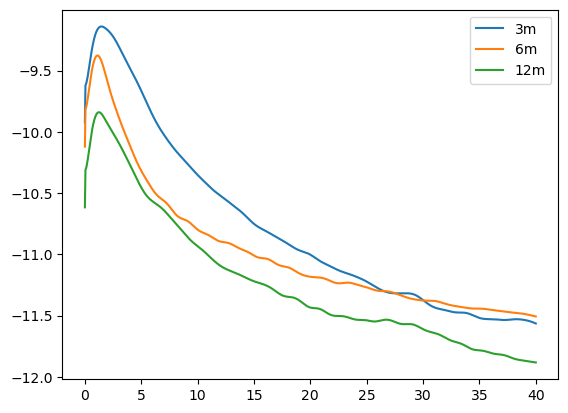

In [46]:
plt.plot(freqs,np.log10(np.mean(np.mean(sub_three_psds,axis=1),axis=0)),label='3m')
plt.plot(freqs,np.log10(np.mean(np.mean(sub_six_psds,axis=1),axis=0)),label='6m')
plt.plot(freqs,np.log10(np.mean(np.mean(sub_twelve_psds,axis=1),axis=0)),label='12m')
plt.legend()

In [47]:
def parameterize_psds(freqs, sub_psds):
    n_chans=sub_psds.shape[1]
    fg = FOOOFGroup()
    fgs=fit_fooof_3d(fg, freqs, sub_psds, [.05, 40])
    
    sub_periodic=np.zeros(sub_psds.shape)
    sub_aperiodic=np.zeros(sub_psds.shape)
    for s_idx, fg in enumerate(fgs):
        for chan in range(n_chans):
            if chan in fg.null_inds_:
                sub_aperiodic[s_idx,chan,:]=float('NaN')
                sub_periodic[s_idx,chan,:]=float('NaN')
            else:
                fm = fg.get_fooof(ind=chan, regenerate=True)
                ap_params=fm.get_params('aperiodic_params')
                sub_aperiodic[s_idx,chan,:] = gen_aperiodic(freqs, ap_params)
              
                sub_periodic[s_idx,chan,:]=np.log10(sub_psds[s_idx,chan,:])-sub_aperiodic[s_idx,chan]
                print(sub_periodic.shape)
    return fgs, sub_periodic, sub_aperiodic

In [48]:
fgs_3m, sub_three_periodic, sub_three_aperiodic=parameterize_psds(freqs, sub_three_psds)
fgs_6m, sub_six_periodic, sub_six_aperiodic=parameterize_psds(freqs, sub_six_psds)
fgs_12m, sub_twelve_periodic, sub_twelve_aperiodic=parameterize_psds(freqs, sub_twelve_psds)

Running FOOOFGroup across 160 power spectra.


/home/ldurieux/miniconda3/envs/devmobeta/lib/python3.13/site-packages/fooof/core/funcs.py:87: RuntimeWarning: divide by zero encountered in log10
  ys = offset - np.log10(xs**exp)


(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)
(20, 8, 801)

/home/ldurieux/miniconda3/envs/devmobeta/lib/python3.13/site-packages/fooof/core/funcs.py:87: RuntimeWarning: divide by zero encountered in log10
  ys = offset - np.log10(xs**exp)


(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)
(21, 8, 801)

/home/ldurieux/miniconda3/envs/devmobeta/lib/python3.13/site-packages/fooof/core/funcs.py:87: RuntimeWarning: divide by zero encountered in log10
  ys = offset - np.log10(xs**exp)


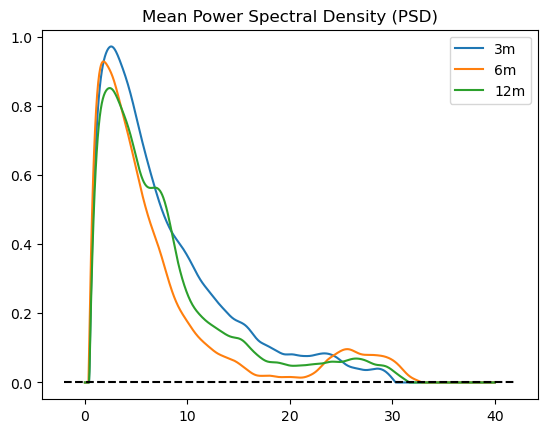

In [49]:
mean_psd_3m=np.mean(np.mean(sub_three_periodic,axis=1),axis=0)
mean_psd_3m[mean_psd_3m<0]=0
mean_psd_6m=np.mean(np.mean(sub_six_periodic,axis=1),axis=0)
mean_psd_6m[mean_psd_6m<0]=0
mean_psd_12m=np.mean(np.mean(sub_twelve_periodic,axis=1),axis=0)
mean_psd_12m[mean_psd_12m<0]=0

plt.plot(freqs,mean_psd_3m,label='3m')
plt.plot(freqs,mean_psd_6m,label='6m')
plt.plot(freqs,mean_psd_12m,label='12m')
plt.plot(plt.xlim(), [0, 0],'k--')
plt.title('Mean Power Spectral Density (PSD)')
plt.legend()

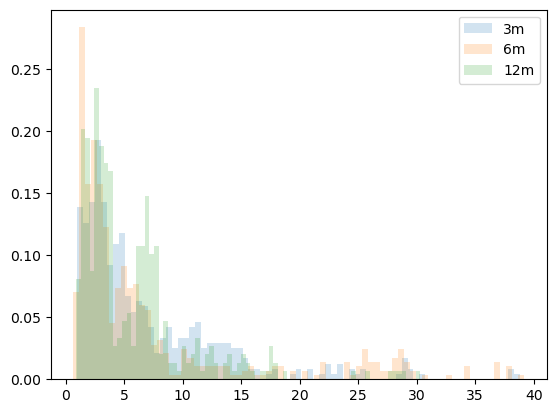

In [50]:
all_peaks_3m=[]
all_peaks_6m=[]
all_peaks_12m=[]
for s_idx, fg in enumerate(fgs_3m):
    for chan in range(len(c_chans)):
        fm = fg.get_fooof(ind=chan, regenerate=True)
        peaks=fm.get_params('peak_params','CF')
        if isinstance(peaks, np.ndarray):
            all_peaks_3m.extend(peaks)
        else:
            all_peaks_3m.append(peaks)
for s_idx, fg in enumerate(fgs_6m):
    for chan in range(len(c_chans)):
        fm = fg.get_fooof(ind=chan, regenerate=True)
        peaks=fm.get_params('peak_params','CF')
        if isinstance(peaks, np.ndarray):
            all_peaks_6m.extend(peaks)
        else:
            all_peaks_6m.append(peaks)
for s_idx, fg in enumerate(fgs_12m):
    for chan in range(len(c_chans)):
        fm = fg.get_fooof(ind=chan, regenerate=True)
        peaks=fm.get_params('peak_params','CF')
        if isinstance(peaks, np.ndarray):
            all_peaks_12m.extend(peaks)
        else:
            all_peaks_12m.append(peaks)
plt.hist(all_peaks_3m,75,alpha=.2,density=True,label='3m')
plt.hist(all_peaks_6m,75,alpha=.2,density=True,label='6m')
plt.hist(all_peaks_12m,75,alpha=.2,density=True,label='12m')
plt.legend()

In [51]:
def define_fois(freqs, mean_psd, age, debug=False):
    mean_resid=mean_psd
    foi_pk_freqs=[]
    foi_pk_vals=[]    
    foi_fwhms=[]
    foi_ranges=[]
    foi_info = {} 
    foi_counter = 1  
    
    orig_pks,properties=scipy.signal.find_peaks(mean_resid)
    while True:
        pks,properties=scipy.signal.find_peaks(mean_resid)

        pk_vals=mean_resid[pks]
        sorted_idx=np.argsort(-pk_vals)
        pk_vals=pk_vals[sorted_idx]
        pks=pks[sorted_idx]

        pk_idx=pks[0]
        pk_val=pk_vals[0]
        pk_freq=freqs[pk_idx]
        
        if pk_val<np.std(mean_resid):
            if debug:
                print('Peak val={}, thresh={}'.format(pk_val,.5*np.std(mean_resid)))
            break
        
        l_idx=np.where(mean_resid[:pk_idx]<=pk_val*.5)[0]
        r_idx=np.where(mean_resid[pk_idx:]<=pk_val*.5)[0]

        if len(l_idx) and len(r_idx):
            l_freq=freqs[l_idx[-1]]
            r_freq=freqs[pk_idx+r_idx[0]]
            r_side=(r_freq-pk_freq)
            l_side=(pk_freq-l_freq)
            fwhm=2*np.min([r_side, l_side])
        elif len(l_idx):
            l_freq=freqs[l_idx[-1]]
            fwhm=2*(pk_freq-l_freq)
        elif len(r_idx):
            r_freq=freqs[pk_idx+r_idx[0]+1]
            fwhm=2*(r_freq-pk_freq)

        l_freq=pk_freq-fwhm*.5
        r_freq=pk_freq+fwhm*.5
        sd=fwhm/(2*np.sqrt(2*np.log(2)))
        A=pk_vals[0]*np.exp(-.5*((freqs-pk_freq)/sd)**2)
        nearest_orig=np.min(np.abs(freqs[np.array(orig_pks)]-pk_freq))
            
        if pk_val>np.std(mean_resid) and ((pk_freq<10 and fwhm>2) or (pk_freq>=10 and fwhm>2.4)):# and nearest_orig<3:
            print('Peak: freq={}, val={}, width={}, range={}-{}'.format(pk_freq, pk_val, fwhm, pk_freq-fwhm*.5, pk_freq+fwhm*.5))
            print('Distance to nearest original peak={}'.format(nearest_orig))
            if debug:
                plt.figure(figsize=(12,4))
                plt.subplot(1,2,1)
                plt.plot(freqs,mean_resid)
                plt.plot(freqs[pks],mean_resid[pks],'ro')
                plt.subplot(1,2,2)
                plt.plot(freqs,mean_resid)
                plt.plot(freqs,A)
            
            foi_pk_freqs.append(pk_freq)
            foi_pk_vals.append(pk_val)
            foi_fwhms.append(fwhm)
            foi_ranges.append([l_freq,r_freq])

            band_name = f'FOI_{foi_counter}'
            foi_info[band_name] = {'frequency_range': [l_freq, r_freq], 'peak_frequency': pk_freq}
            foi_counter += 1
            
        elif debug:
            if not ((pk_freq<10 and fwhm>2) or (pk_freq>=10 and fwhm>2.4)):
                print('Peak: freq={}, fhwm={} to narrow'.format(pk_freq, fwhm))
            if pk_val<=np.std(mean_resid):
                print('Peak: freq={} too low amplitude'.format(pk_freq))
            #if nearest_orig>=3:
            #    print('Peak: freq={} too far from original peaks'.format(pk_freq))

        mean_resid=mean_resid-A
        #mean_resid[mean_resid<0]=0
    sorted_idx=np.argsort(foi_pk_freqs)
    
    foi_pk_freqs=np.array(foi_pk_freqs)
    foi_pk_vals=np.array(foi_pk_vals)
    foi_fwhms=np.array(foi_fwhms)
    foi_ranges=np.array(foi_ranges)
    
    foi_pk_freqs=foi_pk_freqs[sorted_idx]
    foi_pk_vals=foi_pk_vals[sorted_idx]
    foi_fwhms=foi_fwhms[sorted_idx]
    foi_ranges=foi_ranges[sorted_idx,:]

    with open(f'frequency_ranges_{age}_BV.json', 'w') as json_file:
        json.dump(foi_info, json_file)
    
    plt.figure()
    plt.plot(freqs,mean_psd, label='Mean PSD')
    for f_idx in range(foi_ranges.shape[0]):
        sd=foi_fwhms[f_idx]/(2*np.sqrt(2*np.log(2)))
        A=foi_pk_vals[f_idx]*np.exp(-.5*((freqs-foi_pk_freqs[f_idx])/sd)**2)
        plt.plot(freqs,A)
        plt.title(f'Peak Detection for {age} months')
    
    return foi_info, foi_pk_freqs,foi_pk_vals,foi_fwhms,foi_ranges

Peak: freq=2.5500000000000003, val=0.9716190503034954, width=3.5000000000000004, range=0.8-4.300000000000001
Distance to nearest original peak=0.0
Peak: freq=5.95, val=0.5853605648035665, width=3.8000000000000007, range=4.05-7.8500000000000005
Distance to nearest original peak=3.4
Peak: freq=9.8, val=0.3424669503669244, width=4.100000000000001, range=7.75-11.850000000000001
Distance to nearest original peak=7.25
Peak: freq=13.8, val=0.17963192982408951, width=4.199999999999999, range=11.700000000000001-15.9
Distance to nearest original peak=6.300000000000001
Peak: freq=17.900000000000002, val=0.09194433570035258, width=5.200000000000003, range=15.3-20.500000000000004
Distance to nearest original peak=2.1999999999999993
Peak: freq=23.6, val=0.08043049050745929, width=5.600000000000001, range=20.8-26.400000000000002
Distance to nearest original peak=0.25


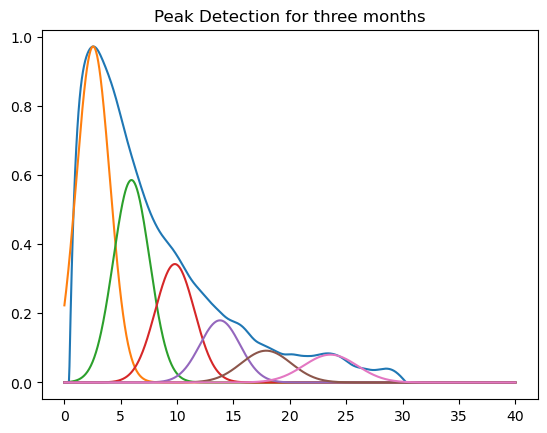

In [52]:
foi_info_3m, foi_pk_freqs_3m,foi_pk_vals_3m,foi_fwhms_3m,foi_ranges_3m=define_fois(freqs, mean_psd_3m, 'three', debug=False)

Peak: freq=1.8, val=0.9281787547648959, width=2.3, range=0.6500000000000001-2.95
Distance to nearest original peak=0.0
Peak: freq=4.2, val=0.673673520781599, width=2.8, range=2.8000000000000003-5.6
Distance to nearest original peak=2.4000000000000004
Peak: freq=7.0, val=0.36624137148567315, width=3.0999999999999996, range=5.45-8.55
Distance to nearest original peak=5.2
Peak: freq=10.05, val=0.14865507224706453, width=3.1000000000000014, range=8.5-11.600000000000001
Distance to nearest original peak=7.800000000000001
Peak: freq=25.6, val=0.09639946105299939, width=5.0, range=23.1-28.1
Distance to nearest original peak=0.0
Peak: freq=13.3, val=0.07158505370893481, width=3.6999999999999993, range=11.450000000000001-15.15
Distance to nearest original peak=4.550000000000001
Peak: freq=29.700000000000003, val=0.055122644754813724, width=3.0999999999999943, range=28.150000000000006-31.25
Distance to nearest original peak=2.0


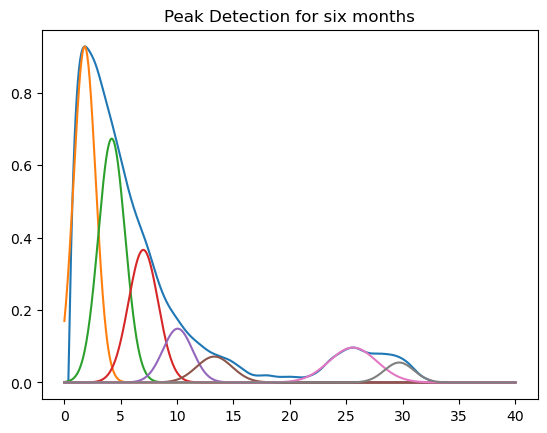

In [53]:
foi_info_6m, foi_pk_freqs_6m,foi_pk_vals_6m,foi_fwhms_6m,foi_ranges_6m=define_fois(freqs, mean_psd_6m, 'six', debug=False)

Peak: freq=2.4000000000000004, val=0.8513721859329373, width=3.3000000000000007, range=0.75-4.050000000000001
Distance to nearest original peak=0.0
Peak: freq=7.0, val=0.5587198415481448, width=5.5, range=4.25-9.75
Distance to nearest original peak=0.1999999999999993
Peak: freq=13.15, val=0.1331318806044391, width=4.599999999999998, range=10.850000000000001-15.45
Distance to nearest original peak=6.35
Peak: freq=26.450000000000003, val=0.06919040840367578, width=7.199999999999996, range=22.850000000000005-30.05
Distance to nearest original peak=0.0
Peak: freq=16.150000000000002, val=0.05760124538100398, width=3.0000000000000036, range=14.65-17.650000000000006
Distance to nearest original peak=8.05
Peak: freq=19.05, val=0.04682690716192464, width=2.799999999999997, range=17.650000000000002-20.45
Distance to nearest original peak=5.150000000000002


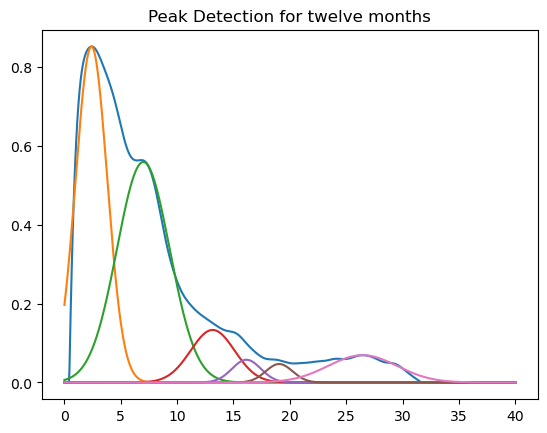

In [54]:
foi_info_12m,foi_pk_freqs_12m,foi_pk_vals_12m,foi_fwhms_12m,foi_ranges_12m=define_fois(freqs, mean_psd_12m, 'twelve', debug=False)

In [55]:
import scipy.io

fname = "processed_psd_three_BV.mat"
output_path = fname  

scipy.io.savemat(output_path,
                 {
                     'frex': freqs,
                     'psd': sub_three_psds,
                     'periodic': sub_three_periodic,
                     'aperiodic': sub_three_aperiodic,
                     'foi_pk_freqs': foi_pk_freqs_3m,
                     'foi_pk_vals': foi_pk_vals_3m,
                     'foi_fwhms': foi_fwhms_3m,
                     'foi_ranges': foi_ranges_3m
                 })  

In [56]:
fname = "processed_psd_six_BV.mat"
output_path = fname  

scipy.io.savemat(output_path,
                 {
                     'frex': freqs,
                     'psd': sub_six_psds,
                     'periodic': sub_six_periodic,
                     'aperiodic': sub_six_aperiodic,
                     'foi_pk_freqs': foi_pk_freqs_6m,
                     'foi_pk_vals': foi_pk_vals_6m,
                     'foi_fwhms': foi_fwhms_6m,
                     'foi_ranges': foi_ranges_6m
                 })  

In [57]:
fname = "processed_psd_twelve_BV.mat"
output_path = fname  

scipy.io.savemat(output_path,
                 {
                     'frex': freqs,
                     'psd': sub_twelve_psds,
                     'periodic': sub_twelve_periodic,
                     'aperiodic': sub_twelve_aperiodic,
                     'foi_pk_freqs': foi_pk_freqs_12m,
                     'foi_pk_vals': foi_pk_vals_12m,
                     'foi_fwhms': foi_fwhms_12m,
                     'foi_ranges': foi_ranges_12m
                 })  

In [58]:
foi_ranges_3m

array([[ 0.8 ,  4.3 ],
       [ 4.05,  7.85],
       [ 7.75, 11.85],
       [11.7 , 15.9 ],
       [15.3 , 20.5 ],
       [20.8 , 26.4 ]])

In [59]:
foi_ranges_6m

array([[ 0.65,  2.95],
       [ 2.8 ,  5.6 ],
       [ 5.45,  8.55],
       [ 8.5 , 11.6 ],
       [11.45, 15.15],
       [23.1 , 28.1 ],
       [28.15, 31.25]])

In [60]:
foi_ranges_12m

array([[ 0.75,  4.05],
       [ 4.25,  9.75],
       [10.85, 15.45],
       [14.65, 17.65],
       [17.65, 20.45],
       [22.85, 30.05]])